In [34]:
%matplotlib inline 

import pandas as pd
import numpy as np
import scipy as sp
import random
import itertools

from sklearn.metrics import explained_variance_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA # Need to try this

In [24]:
# Load The data and Concat into a single big file

binary_sys = pd.read_pickle('binary_sys')
binary_sys['type'] = 'binary'
ternary_sys = pd.read_pickle('tern_data')
ternary_sys['type'] = 'ternary'

data = pd.concat([binary_sys,ternary_sys], ignore_index= True)


In [25]:
#  define a shuffle function:

def partition(lst, n): 
    random.shuffle(lst)
    division = len(lst) / float(n) 
    return [ lst[int(round(division * i)): int(round(division * (i + 1)))] for i in xrange(n) ]


In [26]:
# Extract feature column
 
features = list(data.columns)
features = [f for f in features if (f.endswith('prop') 
                                    or f.startswith('prop') 
                                    or f.startswith(('avg','max')) 
                                    or f in 'ABC' 
                                    or f == 'formation_energy'
                                    or f == 'type')]
                                    
data = data[features]
data = data.fillna(0)
data = data.reset_index(drop=True)

Y = 'formation_energy'
X = list(set(features) - set(['formation_energy','type','A','B','C']))

# skf = StratifiedKFold(data.type,n_folds=10)

In [27]:
# Builds a single decision tree using the methodoloy
# X: a data frame of X dependant vectors
# Y: a data fame of Y response values
# k: The number of predictor variables to use in each rotatation
# rows.use.frac: The fraction of data points to use in each model of the ensemble

def generate_model(X,Y):
    M = 10
    col_shuffle_set = partition(list(X.columns),M)
    col_order = list(itertools.chain(*col_shuffle_set))
    temp = []
    for colset in col_shuffle_set:
        samp = X[colset]
        sub_samp = samp.sample(frac = 0.75, axis = 0)
        pca = PCA(n_components = len(colset))
        fit = pca.fit(sub_samp[colset])
        temp.append(pd.DataFrame(fit.components_,columns=  colset))
    rot_array = sp.linalg.block_diag(*temp)
    rot_df = pd.DataFrame(rot_array, columns = col_order)
    original_col = X.columns.tolist() # get original column order
    
    rot_df = rot_df[original_col] # rearrange the DF to the original column order
    rot_df = rot_df.transpose()
    
    train_X = X.dot(rot_df)# Generate the new training data
    
    dtree = DecisionTreeRegressor()
    model = dtree.fit(train_X,Y)
    
    return model
    
    

In [ ]:
result_y = []
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]
train_X,test_X,train_Y,test_Y = train[X],test[X],train[Y],test[Y]
for i in xrange(10):
    model = generate_model(train_X,train_Y)
    predict_y = model.predict(test_X)
    result_y.append(predict_y)
    

    

In [35]:
# K fold Cross Validation:

skf = KFold(data.shape[0], n_folds= 10, shuffle= True)
cv_kfold = []
one_forest = []
for train_index,test_index in skf:
    for i in xrange(10):
        model = generate_model(data.loc[train_index,X],data.loc[train_index,Y])
        predict = model.predict(data.loc[test_index,X])
        one_forest.append(predict)
    k = pd.DataFrame(one_forest)
    k = k.transpose()
    mean_y = k.mean(axis = 1)
    print len(cv_kfold)
    cv_kfold.append((data.loc[test_index,Y],mean_y))

0
1


ValueError: Found array with dim 8647. Expected 8646

In [36]:
cv_kfold

[0.025614625976076888]

In [50]:
k = pd.DataFrame(result_y)
k = k.transpose()
mean_y = k.mean(axis = 1)
print len(test_X)
print len(test_Y)

17146
17146


/Users/avinana/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


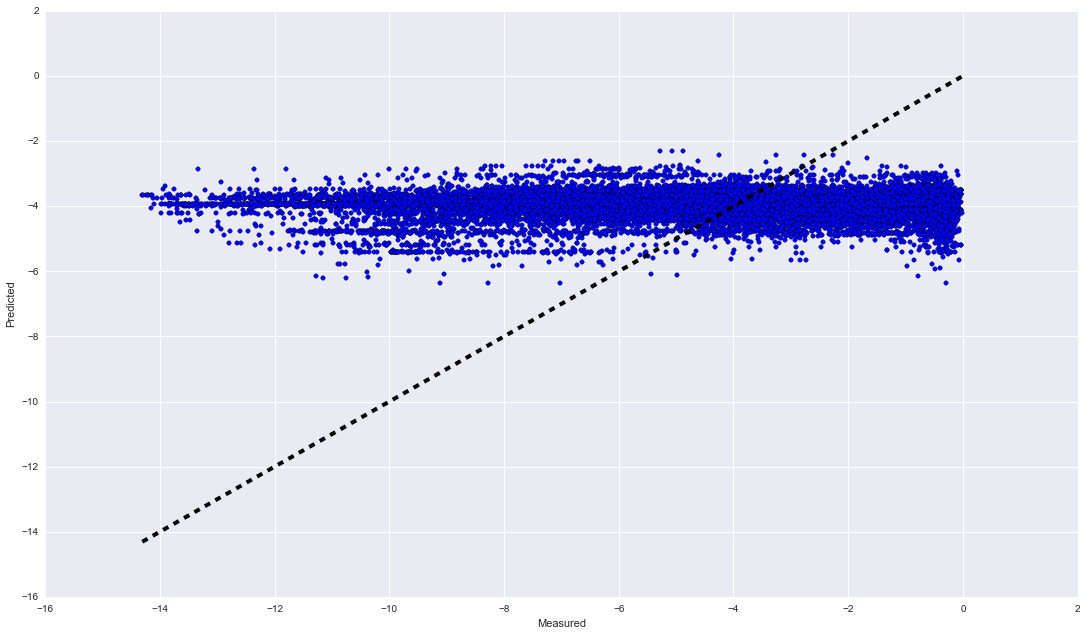

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style("darkgrid")

fig,ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax.scatter(test_Y, mean_y)
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.show()

In [ ]:
'''
Scratch work 

'''

type(data.shape[1])

import random
def partition(lst, n): 
    random.shuffle(lst)
    division = len(lst) / float(n) 
    return [ lst[int(round(division * i)): int(round(division * (i + 1)))] for i in xrange(n) ]



junk = partition(X,10)
train,test = train_test_split(data[junk[1]],test_size = 0.25)
pca = PCA(n_components = len(junk[1]))
temp = pca.fit(data[junk[1]])
pd.DataFrame(temp.components_,columns=  junk[1])
print junk[1]